<a href="https://colab.research.google.com/github/benihime91/pytorch_retinanet/blob/master/references/train_pascal_2007.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# what GPU do we have ?
!nvidia-smi

Sun Aug 30 06:48:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Ensure colab doesn't disconnect
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

In [3]:
%%bash
# # GitHub repo sync & install the dependencies
git clone https://github.com/benihime91/pytorch_retinanet.git
pip install -U pytorch-lightning --quiet 
pip install -U git+https://github.com/albumentations-team/albumentations --quiet
# unzip the Pascal-VOC-2007 data from GDrive
tar xf /content/drive/My\ Drive/Data/VOCtrainval_06-Nov-2007.tar -C /content/ 
echo ">> Setup Done !!"

>> Setup Done !!


Cloning into 'pytorch_retinanet'...
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 2.2.0 which is incompatible.


In [3]:
import warnings
import os

annot_dir = '/content/VOCdevkit/VOC2007/Annotations'
image_dir = '/content/VOCdevkit/VOC2007/JPEGImages'
os.chdir('/content/pytorch_retinanet/')

warnings.filterwarnings("ignore")
%matplotlib inline

In [4]:
# # install wandb - weight's & biases
# ! pip install --upgrade wandb
# ! wandb login 

In [5]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, LearningRateLogger
from src.models import Retinanet

from src.utils.eval_utils import CocoEvaluator
from src.utils.eval_utils import get_coco_api_from_dataset
from src.utils.general_utils import xml_to_csv
from src.utils.general_utils import Visualizer
from src.utils.general_utils import collate_fn

pl.seed_everything(42)
pd.set_option('display.max_colwidth', None)

## Preprare the Data:

Use the script `xml_to_csv` to convert the `Pascal XML Annotations` into `csv` format so that data loading becomes easier.

In [6]:
# Prepare the Data
df = xml_to_csv(annot_dir)
df['filename'] = [os.path.join(image_dir, i) for i in df.filename.values]

le = LabelEncoder()
int_cls = le.fit(df['class'].unique())
df['labels'] = le.transform(df['class'])

df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,labels
0,/content/VOCdevkit/VOC2007/JPEGImages/005110.jpg,500,375,car,83,33,384,152,6
1,/content/VOCdevkit/VOC2007/JPEGImages/005110.jpg,500,375,car,405,96,461,142,6
2,/content/VOCdevkit/VOC2007/JPEGImages/005110.jpg,500,375,car,2,158,133,287,6
3,/content/VOCdevkit/VOC2007/JPEGImages/005110.jpg,500,375,car,126,176,189,232,6
4,/content/VOCdevkit/VOC2007/JPEGImages/005110.jpg,500,375,car,180,186,206,217,6


In [7]:
names = list(df.labels.unique())
names.sort()
# Create the label dictionary
label_dict = {idx:clas for idx, clas in zip(names, list(le.inverse_transform(names)))}

# Instantiate the visualizer
viz = Visualizer(class_names=label_dict)

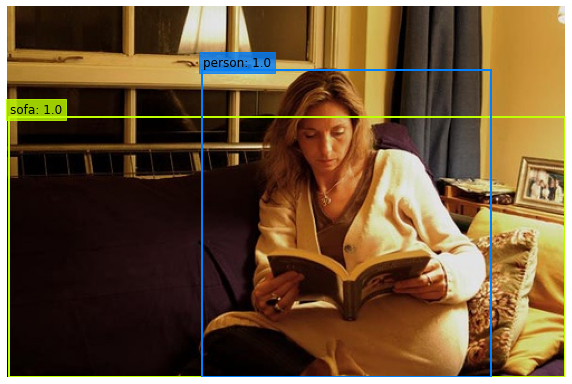

In [8]:
# @title Image {run:"auto", vertical-output:true, display-mode:"form"}
n = 6638  #@param {type: "slider", min: 0, max: 15662}

fname = df['filename'][n]
boxes = df.loc[df['filename'] == fname][['xmin', 'ymin', 'xmax', 'ymax']].values
labels = df.loc[df['filename'] == fname]['labels'].values
viz.draw_bboxes(fname, boxes=boxes, classes=labels, figsize=(10,10))

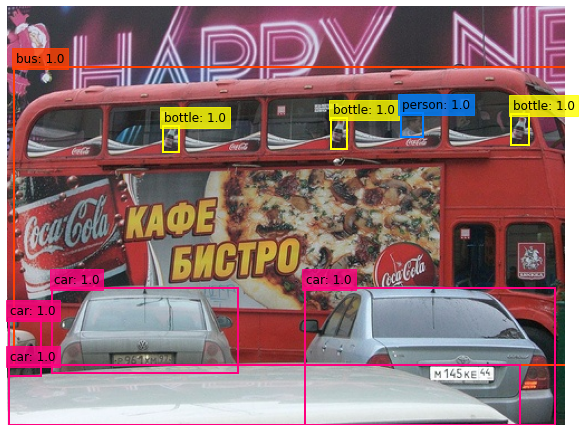

In [9]:
# @title Image {run:"auto", vertical-output:true, display-mode:"form"}
n = 14172  #@param {type: "slider", min: 0, max: 15662}

fname = df['filename'][n]
boxes = df.loc[df['filename'] == fname][['xmin', 'ymin', 'xmax', 'ymax']].values
labels = df.loc[df['filename'] == fname]['labels'].values
viz.draw_bboxes(fname, boxes=boxes, classes=labels, figsize=(10,10))

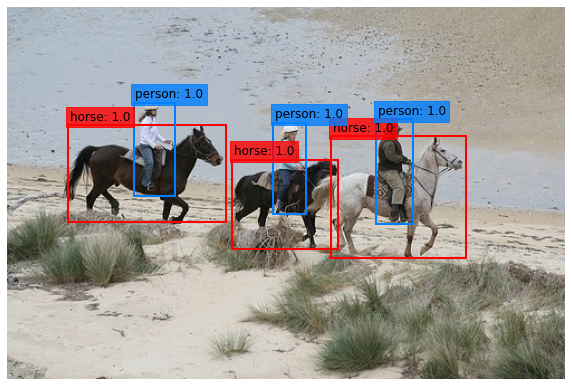

In [10]:
# @title Image {run:"auto", vertical-output:true, display-mode:"form"}
n = 95  #@param {type: "slider", min: 0, max: 15662}

fname = df['filename'][n]
boxes = df.loc[df['filename'] == fname][['xmin', 'ymin', 'xmax', 'ymax']].values
labels = df.loc[df['filename'] == fname]['labels'].values
viz.draw_bboxes(fname, boxes=boxes, classes=labels, figsize=(10,10))

In [11]:
# -------------------------------------------------- #
# Grab the Unique Image Idxs from the Filename
# -------------------------------------------------- #
unique_ids = list(df.filename.unique())

# --------------------------------------------------------- #
# Split the Unique Image Idxs into Train & valid Datasets
# --------------------------------------------------------- #
test_ids, val_ids = train_test_split(unique_ids, shuffle=True, random_state=42, test_size=0.2)

# -------------------------------------------------- #
# Create Splits on the DataFrame
# -------------------------------------------------- #
df["split"] = 0

for i,idx in enumerate(df.filename.values):
    if idx in set(test_ids)  : 
        df["split"][i] = "train"
    elif idx in set(val_ids) : 
        df["split"][i] = "val"

# -------------------------------------------------- #
# Split the DataFrame into Train and Test DataFrames
# -------------------------------------------------- #
df_trn, df_val = df.loc[df["split"] == "train"], df.loc[df["split"] == "val"]

df_trn, df_val = df_trn.reset_index(drop=True),df_val.reset_index(drop=True)

# -------------------------------------------------- #
# Save the DataFrames
# -------------------------------------------------- #
df_trn.to_csv('/content/drive/My Drive/Data/PascalVocTrain.csv',
              index=False)
df_val.to_csv('/content/drive/My Drive/Data/PascalVocValid.csv',
              index=False)

In [12]:
df_train = pd.read_csv('/content/drive/My Drive/Data/PascalVocTrain.csv')
df_train.head(3)

,filename,width,height,class,xmin,ymin,xmax,ymax,labels,split
0,/content/VOCdevkit/VOC2007/JPEGImages/005110.jpg,500,375,car,83,33,384,152,6,train
1,/content/VOCdevkit/VOC2007/JPEGImages/005110.jpg,500,375,car,405,96,461,142,6,train
2,/content/VOCdevkit/VOC2007/JPEGImages/005110.jpg,500,375,car,2,158,133,287,6,train


In [13]:
df_val = pd.read_csv('/content/drive/My Drive/Data/PascalVocValid.csv')
df_val.head(3)

,filename,width,height,class,xmin,ymin,xmax,ymax,labels,split
0,/content/VOCdevkit/VOC2007/JPEGImages/002855.jpg,500,375,sofa,215,192,475,374,17,val
1,/content/VOCdevkit/VOC2007/JPEGImages/002855.jpg,500,375,person,181,142,373,337,14,val
2,/content/VOCdevkit/VOC2007/JPEGImages/007923.jpg,500,235,chair,397,106,450,179,8,val


## Instantiate Transformations:

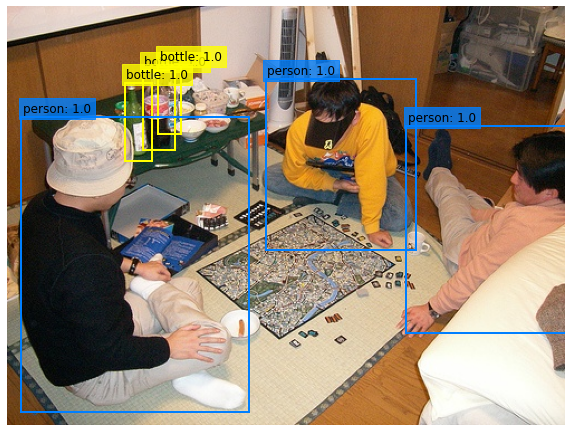

In [15]:
# @title Original Image {run:"auto", vertical-output:true, display-mode:"form"}
# -------------------------------------------------- #
# Grab and Display a Random Image
# -------------------------------------------------- #
n = 8343  #@param {type: "slider", min: 0, max: 15662}

fname = df['filename'][n]
boxes = df.loc[df['filename'] == fname][['xmin',
                                         'ymin',
                                         'xmax',
                                         'ymax']].values
                                         
labels = df.loc[df['filename'] == fname]['labels'].values

viz.draw_bboxes(fname, boxes=boxes, classes=labels, figsize=(10,10))

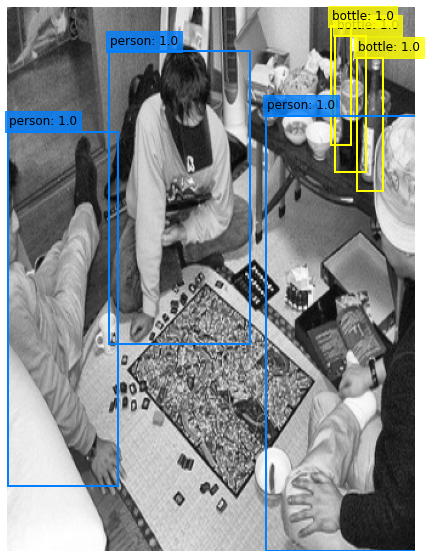

In [17]:
# @title Transformed Image: { run: "auto", vertical-output: true, display-mode: "form" }

# -------------------------------------------------- #
# Apply augmentations on the Grabbed Image
# -------------------------------------------------- #

alpha = 2.7  # @param {type:"slider", min:0, max:5, step:0.1}
width = 448  # @param {type:'integer'}
height = 336  # @param {type:'integer'}
erosion_rate = 0.4  # @param {type:"slider", min:0, max:1, step:0.1}
to_gray = 0.2  # @param {type:"slider", min:0, max:1, step:0.1}


tfms = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.CLAHE(),
        A.OneOf([A.HueSaturationValue(), A.RandomBrightnessContrast(),]),
        A.ToGray(p=to_gray),
        A.RandomSizedBBoxSafeCrop(width, height, erosion_rate=erosion_rate, p=0.2),
    ],
    bbox_params=A.BboxParams(format="pascal_voc", label_fields=["class_labels"]),
)


fname = df["filename"][n]
im = cv2.cvtColor(cv2.imread(df["filename"][n]), cv2.COLOR_BGR2RGB)
boxes = df.loc[df["filename"] == fname][["xmin", "ymin", "xmax", "ymax"]].values
labels = df.loc[df["filename"] == fname]["labels"].values

transformed = tfms(image=im, bboxes=boxes, class_labels=labels)

image = transformed["image"]
boxes = transformed["bboxes"]
labels = transformed["class_labels"]

viz.draw_bboxes(image, boxes=boxes, classes=labels, figsize=(10, 10))

In [14]:
# -------------------------------------------------- #
# Train Transformations :
# -------------------------------------------------- #
train_transformations = [
    A.HorizontalFlip(p=0.5),
    A.CLAHE(),
    A.OneOf([
        A.HueSaturationValue(),
        A.RandomBrightnessContrast(), 
    ]),
    A.ToGray(p=0.2),
    A.RandomSizedBBoxSafeCrop(width=448, height=336, erosion_rate=0.2, p=0.2),
    A.ToFloat(max_value=255.0, always_apply=True),
    ToTensorV2(always_apply=True),
]

# -------------------------------------------------- #
# Valid Transformations :
# -------------------------------------------------- #
valid_transformations = [A.ToFloat(max_value=255.0, always_apply=True), ToTensorV2(always_apply=True)]

# -------------------------------------------------- #
# Transformations :
# -------------------------------------------------- #
transforms = {
    "train": A.Compose(train_transformations, p=1.0, 
                       bbox_params=A.BboxParams(format="pascal_voc",label_fields=["class_labels"])),
    "valid": A.Compose(valid_transformations,p=1.0,
                       bbox_params=A.BboxParams(format="pascal_voc", label_fields=["class_labels"]))
    }

## Create `torch.utils.data.Dataset` class:

In [15]:
class PascalDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, train):
        
        self.df = dataframe
        
        self.image_ids = self.df["filename"]
        
        if train:
            self.tfms = transforms["train"]
        else:
            self.tfms = transforms["valid"]

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        # -------------------------------------------------- #
        # Grab the Image
        # -------------------------------------------------- #
        image_id = self.image_ids[idx]
        im = cv2.cvtColor(cv2.imread(image_id), cv2.COLOR_BGR2RGB)

        # -------------------------------------------------- #
        # extract the bounding boxes
        # -------------------------------------------------- #
        records = self.df[self.df["filename"] == image_id]
        boxes = records[["xmin", "ymin", "xmax", "ymax"]].values
        
        # -------------------------------------------------- #
        # claculate area
        # -------------------------------------------------- #
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        
        # -------------------------------------------------- #
        # Grab the Class Labels
        # -------------------------------------------------- #
        class_labels = records["labels"].values.tolist()
        
        # -------------------------------------------------- #
        # suppose all instances are not crowd
        # -------------------------------------------------- #
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        # -------------------------------------------------- #
        # apply transformations
        # -------------------------------------------------- #
        transformed = self.tfms(image=im, bboxes=boxes, class_labels=class_labels)
        image = transformed["image"]
        boxes = torch.tensor(transformed["bboxes"], dtype=torch.float32)
        class_labels = torch.tensor(transformed["class_labels"])
        
        # -------------------------------------------------- #
        # target dictionary
        # -------------------------------------------------- #
        target = {}
        image_idx = torch.tensor([idx])

        target["image_id"] = image_idx
        target["boxes"]    = boxes
        target["labels"]   = class_labels
        target["area"]     = area
        target["iscrowd"]  = iscrowd
        
        return image, target, image_idx

## Create `pl.LightningModule`:

In [19]:
class PascalModel(pl.LightningModule):
    def __init__(
        self,
        model: nn.Module,
        train_dl: torch.utils.data.DataLoader,
        val_dl: torch.utils.data.DataLoader,
        learning_rate: float,
    ):

        super(PascalModel, self).__init__()
        self.model = model
        self.train_dl = train_dl
        self.val_dl = val_dl
        self.learning_rate = learning_rate
        
        self.lr_steps = [16, 22]
        self.lr_gamma = 0.1
        self.warmup_iters = min(1000, len(train_dl) - 1)
        self.warmup_factor = 1.0 / 1000

    def train_dataloader(self, *args, **kwargs):
        return self.train_dl

    def val_dataloader(self, *args, **kwargs):
        valid_loader = self.val_dl
        coco = get_coco_api_from_dataset(valid_loader.dataset)
        iou_types = ["bbox"]
        self.coco_evaluator = CocoEvaluator(coco, iou_types)
        return valid_loader

    def configure_optimizers(self, *args, **kwargs):
        params = [p for p in self.model.parameters() if p.requires_grad]
        # Optimizer
        self.optimizer = optim.SGD(
            params,
            lr=((self.learning_rate or self.lr)),
            momentum=0.9,
            weight_decay=1e-02,
        )
        # Scheduler for Lr Warm-up
        self.scheduler_1 = self.warmup_lr_scheduler(
            self.optimizer, self.warmup_iters, self.warmup_factor
            )
        # StepLrScheduler
        self.scheduler_2 = {
            "scheduler": optim.lr_scheduler.MultiStepLR(
                self.optimizer, milestones=self.lr_steps, gamma=self.lr_gamma
            ),
            "interval": "epoch",
            "frequency": 1,
        }
        return [self.optimizer], [self.scheduler_2]

    def warmup_lr_scheduler(self, optimizer, warmup_iters, warmup_factor):
        def f(x):
            if x >= warmup_iters:
                return 1
            alpha = float(x) / warmup_iters
            return warmup_factor * (1 - alpha) + alpha
        return torch.optim.lr_scheduler.LambdaLR(optimizer, f)

    def optimizer_step(self, current_epoch, batch_nb, optimizer, *args, **kwargs):
        # update params
        optimizer.step()
        optimizer.zero_grad()
        self.scheduler_1.step()

    def forward(self, xb, *args, **kwargs):
        return self.model(xb)

    def training_step(self, batch, batch_idx, *args, **kwargs):
        images, targets, _ = batch
        targets = [{k: v for k, v in t.items()} for t in targets]
        loss_dict = self.model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        return {"loss": losses, "log": loss_dict, "progress_bar": loss_dict}

    def validation_step(self, batch, batch_idx, *args, **kwargs):
        images, targets, _ = batch
        targets = [{k: v for k, v in t.items()} for t in targets]
        outputs = self.model(images, targets)
        res = {
            target["image_id"].item(): output
            for target, output in zip(targets, outputs)
        }
        self.coco_evaluator.update(res)
        return {}

    def validation_epoch_end(self, outputs, *args, **kwargs):
        self.coco_evaluator.accumulate()
        self.coco_evaluator.summarize()
        metric = self.coco_evaluator.coco_eval["bbox"].stats[0]
        metric = torch.as_tensor(metric)
        logs = {"bbox_iou": metric}

        return {
            "val_loss": metric,
            "log": logs,
            "progress_bar": logs,
        }

## Configs:

In [17]:
# -------------------------------------------------- #
# @title Configs :
# -------------------------------------------------- #
TRAIN_BATCH_SIZE = 5 #@param
VALID_BATCH_SIZE = 20 #@param
LR = 1e-03 #@param
NUM_CLASSES = 20  #@param
# PascalVoc 2007 has 20 disctinct classes

## Train `model`:

In [18]:
# -------------------------------------------------- #
# Load RetinaNet Model with resnet50 backbone
# pretrained on Image net Dataset
# -------------------------------------------------- #
model = Retinanet(
    num_classes=NUM_CLASSES, backbone_kind="resnet50", pretrained=True, freeze_bn=True
)

# -------------------------------------------------- #
# DataLoaders
# -------------------------------------------------- #
train_dl = DataLoader(
    PascalDataset(df_train, train=True),
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
    pin_memory=True,
)

val_dl = DataLoader(
    PascalDataset(df_val, train=False),
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
    pin_memory=True,
)

# ----------------------------------------------------------------- #
# Instantiate vanilla `Trainer` & `Ligntning model` for `lr_finder`
# ----------------------------------------------------------------- #
model = PascalModel(model, train_dl, val_dl, learning_rate=LR,)
trainer = pl.Trainer(num_sanity_val_steps=0, precision=16, gpus=1)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.


### run `lr_finder`:


  | Name  | Type      | Params
------------------------------------
0 | model | Retinanet | 36 M  


creating index...
index created!


Saving latest checkpoint..


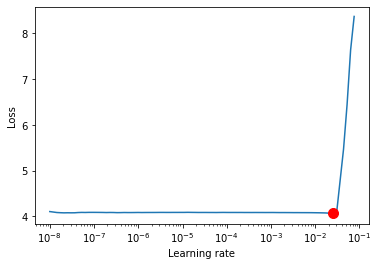

In [ ]:
# ----------------------------------------------------------------- #
# `lr_finder`
# ----------------------------------------------------------------- #
lr_finder = trainer.lr_find(model)
fig = lr_finder.plot(suggest=True)
fig.show()

### set new `learning_rate`

In [25]:
# Wandb logger
wb_logger = WandbLogger(name="stage-03", project="pascal-2007")

# Learning_rate logger to monitor learning_rate
lr_logger = LearningRateLogger(logging_interval="step")

# checkpoin callback
checkpoint_callback = ModelCheckpoint(
    filepath="/content/drive/My Drive/checkpoints/",
    mode="max",
    monitor="bbox_iou",
    verbose=True,
    save_weights_only=True,
    save_top_k=-1,
)

# early stopping callback
early_stopping_callback = EarlyStopping(mode="max", monitor="bbox_iou", patience=5)

# Trainer
trainer = pl.Trainer(
    logger=[wb_logger],
    callbacks=[lr_logger],
    num_sanity_val_steps=0,
    early_stop_callback=early_stopping_callback,
    checkpoint_callback=checkpoint_callback,
    max_epochs=25,
    terminate_on_nan=True,
    precision=16,
    gpus=1,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.


In [ ]:
# Set new lr
new_lr = 1e-02
model.hparams.lr = new_lr

# ----------------------------------------------------------------- #
# Train the Model with Lightning Trainer
# ----------------------------------------------------------------- #
trainer.fit(model)


  | Name  | Type      | Params
------------------------------------
0 | model | Retinanet | 36 M  


creating index...
index created!


In [ ]:
torch.save(model.state_dict(), '/content/drive/My Drive/pascal_voc_2007.pth')